<a href="https://colab.research.google.com/github/Jabullae/Deep_Learning/blob/main/CNN_%EC%82%AC%EC%A0%84%ED%9B%88%EB%A0%A8%EB%90%9C_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

KeyError: ignored

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jabullae","key":"9615fe6e84855ac0d22aa288ab5d10bd"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c dogs-vs-cats

 98% 798M/812M [00:06<00:00, 190MB/s]
100% 812M/812M [00:06<00:00, 123MB/s]


In [7]:
! unzip -qq dogs-vs-cats.zip
! unzip -qq train.zip

# 사전 훈련된 모델을 사용한 특성 추출

## VGG16 합성곱 기반 층 만들기

In [8]:
from tensorflow import keras

In [9]:
conv_base = keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (180, 180, 3))

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

# 데이터 증식을 사용하지 않는 빠른 특성 추출

## VGG16 특성과 해당 레이블 추출하기

In [11]:
import os, shutil, pathlib

original_dir = pathlib.Path('train')
new_base_dir = pathlib.Path('cats_vs_dogs_small')
def make_subset(subset_name, start_index, end_index):
    for category in('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f'{category}.{i}.jpg'
                 for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src = original_dir / fname, 
                           dst = dir / fname)
            
make_subset('train', start_index = 0, end_index = 1000)
make_subset('validation', start_index = 1000, end_index = 1500)
make_subset('test', start_index = 1500, end_index = 2500)

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size = (180, 180),
    batch_size = 32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size = (180, 180),
    batch_size = 32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size = (180, 180),
    batch_size = 32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [13]:
from tensorflow import keras

In [14]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 23ms/step


## 밀집 연결 분류기 정의하고 훈련하기

In [15]:
from keras import layers

In [16]:
inputs = keras.Input(shape = (5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'feature_extraction.keras',
        save_best_only = True,
        monitor = 'val_loss')
]

history = model.fit(
    train_features, train_labels,
    epochs = 20,
    validation_data = (val_features, val_labels),
    callbacks = callbacks)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 29.0897 - accuracy: 0.9150 - val_loss: 3.4908 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 3.5324 - accuracy: 0.9770 - val_loss: 4.2555 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 3.3949 - accuracy: 0.9775 - val_loss: 3.4982 - val_accuracy: 0.9770
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8340 - accuracy: 0.9935 - val_loss: 3.6672 - val_accuracy: 0.9800
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9188 - accuracy: 0.9930 - val_loss: 4.6066 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.1099 - accuracy: 0.9920 - val_loss: 7.8851 - val_accuracy: 0.9650
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.2057 - accuracy: 0.9965 - val_loss: 5.8482 - val_accuracy: 0.9730
Epoch 8/20
63/63 [

## 결과를 그래프로 나타내기

In [17]:
model.evaluate(test_featrues, test_labels)

NameError: ignored

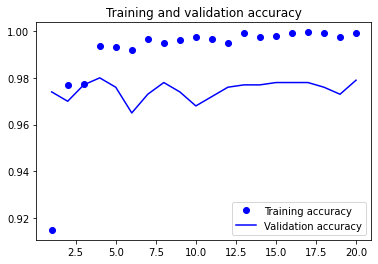

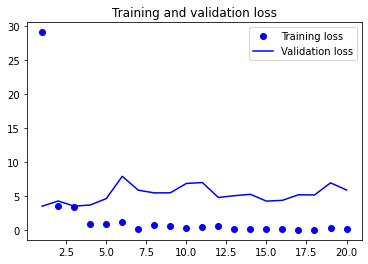

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 데이터 증식을 사용한 특성 추출

## VGG16 합성곱 기반 층을 만들고 동결하기

In [19]:
conv_base = keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False)
conv_base.trainable = False

## 동결하기 전과 후에 훈련 가능한 가중치 리스트 출력하기

In [20]:
conv_base.trainable = True
print('합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수 : ',
     len(conv_base.trainable_weights))

conv_base.trainable = False
print('합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수 : ',
     len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수 :  26
합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수 :  0


## 데이터 증식 단계와 밀집 분류기를 합성곱 기반 층에 추가하기

In [21]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'feature_extraction_with_data_augmentation.keras',
        save_best_only = True,
        monitor = 'val_loss')
]

history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/50
63/63 [==============================] - 14s 202ms/step - loss: 17.3219 - accuracy: 0.8995 - val_loss: 2.9021 - val_accuracy: 0.9790
Epoch 2/50
63/63 [==============================] - 13s 198ms/step - loss: 7.5096 - accuracy: 0.9435 - val_loss: 4.7002 - val_accuracy: 0.9770
Epoch 3/50
63/63 [==============================] - 14s 212ms/step - loss: 7.4559 - accuracy: 0.9515 - val_loss: 6.4811 - val_accuracy: 0.9680
Epoch 4/50
63/63 [==============================] - 13s 201ms/step - loss: 5.3618 - accuracy: 0.9580 - val_loss: 3.7103 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 13s 204ms/step - loss: 4.9807 - accuracy: 0.9600 - val_loss: 4.7062 - val_accuracy: 0.9770
Epoch 6/50
63/63 [==============================] - 13s 207ms/step - loss: 3.4645 - accuracy: 0.9685 - val_loss: 5.2643 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 13s 207ms/step - loss: 3.0804 - accuracy: 0.9735 - val_loss: 3.2366 - val_accuracy: 0.982